In [13]:
import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
import numpy as np
import os
import nrrd
import pytorch_lightning as pl #python -m pip install lightning
from monai.data import CacheDataset, DataLoader
from monai.transforms import Compose, Lambda, RandSpatialCrop, RandRotate90, ToTensor, ScaleIntensityRange
from monai.networks.nets import AutoEncoder
from monai.losses import SSIMLoss
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler
import time

In [11]:
#Using AutoEncoder instead of UNet to avoid skip connections 
class SlicePlotter:
    def __init__(self):
        pass

    def plot_slices(self, original_slice, reconstruction_slice, title):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(original_slice, cmap='gray')
        plt.title(f'Original {title} Slice')
        plt.subplot(1, 2, 2)
        plt.imshow(reconstruction_slice, cmap='gray')
        plt.title(f'Reconstructed {title} Slice')
        plt.show()

class AutoEncoderModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.autoencoder = AutoEncoder(
            spatial_dims=3, 
            in_channels=1,  
            out_channels=1,  
            channels=(16, 32, 64, 128, 256), 
            strides=(2, 2, 2, 2, 2), 
            kernel_size=3, 
            num_res_units=2
        )
        self.loss_function = SSIMLoss(spatial_dims=3)
        self.slice_plotter = SlicePlotter()

    def forward(self, x):
        return self.autoencoder(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.unsqueeze(1)  # Add channel dimension
        y = y.unsqueeze(1)  # Add channel dimension
        x_hat = self(x)
        
        # Ensure y_pred has the correct shape (batch_size, 1, height, width, depth)
        y_pred = x_hat 
        
        loss = self.loss_function(y_pred, y)
        self.log('train_loss', loss)

        if self.current_epoch % 300 == 0 and batch_idx == 0:
            for _ in range(3):  # Plot 3 random slices
                slice_idx = torch.randint(0, x.shape[2], (1,)).item()
                original_slice = x[0, 0, slice_idx, :, :].detach().cpu().numpy()
                reconstruction_slice = x_hat[0, 0, slice_idx, :, :].detach().cpu().numpy()
                self.slice_plotter.plot_slices(original_slice, reconstruction_slice, 'Train')

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.unsqueeze(1)  # Add channel dimension
        y = y.unsqueeze(1)  # Add channel dimension
        x_hat = self(x)
        
        # Ensure y_pred has the correct shape (batch_size, 1, height, width, depth)
        y_pred = x_hat 
        
        loss = self.loss_function(y_pred, y)
        self.log('val_loss', loss, prog_bar=True)

        if self.current_epoch % 300 == 0 and batch_idx == 0:
            for _ in range(3):  # Plot 3 random slices
                slice_idx = torch.randint(0, x.shape[2], (1,)).item()
                original_slice = x[0, 0, slice_idx, :, :].detach().cpu().numpy()
                reconstruction_slice = x_hat[0, 0, slice_idx, :, :].detach().cpu().numpy()
                self.slice_plotter.plot_slices(original_slice, reconstruction_slice, 'Val')

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

class MyDataset(CacheDataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.files = [f for f in os.listdir(data_dir) if f.endswith('.nrrd')]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.files[idx])
        data, header = nrrd.read(file_path)
        if self.transform:
            data = self.transform(data)
        return data, data

class PlotLossCallback(pl.Callback):
    def __init__(self, log_dir):
        super().__init__()
        self.writer = SummaryWriter(log_dir)

    def on_train_epoch_end(self, trainer, pl_module, **kwargs):
        epoch = trainer.current_epoch
        train_loss = trainer.callback_metrics['train_loss'].cpu().item()
        val_loss = trainer.callback_metrics['val_loss'].cpu().item()

        self.writer.add_scalars('Loss', {'training': train_loss, 'validation': val_loss}, global_step=epoch + 1)
        time_spent = time.time() - start_time
        print(f"Time Spent {time_spent:.2f}")
    def on_train_end(self, trainer, pl_module):
        self.writer.close()

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath= folder_path,
    filename='AE_SSIM{epoch}.pth',
    save_last=True,
    verbose=True,
    every_n_epochs=200
)

transform = Compose([
    Lambda(func=lambda x: np.expand_dims(x, 0) if x.ndim == 3 else x),
    RandSpatialCrop((256, 256, 256), random_size=False),
    RandRotate90(prob=0.5),
    ScaleIntensityRange(a_min=-1310, a_max=3310, b_min=-1, b_max=1, clip=True),  # Normalize between -1 and 1
    ToTensor(dtype=torch.float32)
])
start_time = time.time()
device = torch.device("cuda" if torch.cuda.is_available() else "gpu")

folder_path = "./Models"
if not os.path.exists(folder_path):
        os.makedirs(folder_path)

train_data_dir = "Z:/RA4/train70"
val_data_dir = "Z:/RA4/val30"

train_dataset_uc = MyDataset(train_data_dir, transform)
val_dataset_uc   = MyDataset(val_data_dir  , transform)

train_dataset = CacheDataset(train_dataset_uc, transform=transform, num_workers=0)
val_dataset   = CacheDataset(val_dataset_uc,   transform=transform, num_workers=0)

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True,  num_workers=2)
val_dataloader   = DataLoader(val_dataset,   batch_size=2, shuffle=False, num_workers=2)

trainer = pl.Trainer(
    max_epochs=1500,
    callbacks=[PlotLossCallback("../../logs/"), checkpoint_callback],
    profiler='simple'
)

Loading dataset: 100%|██████████| 8/8 [01:16<00:00,  9.53s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


c:\Users\tgafrick\Documents\Github\RA4-Project\venv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:652: Checkpoint directory C:\Users\tgafrick\Documents\Github\RA4-Project\images\Model exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type        | Params
----------------------------------------------
0 | autoencoder   | AutoEncoder | 6.5 M 
1 | loss_function | SSIMLoss    | 0     
----------------------------------------------
6.5 M     Trainable params
0         Non-trainable params
6.5 M     Total params
25.892    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\tgafrick\Documents\Github\RA4-Project\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

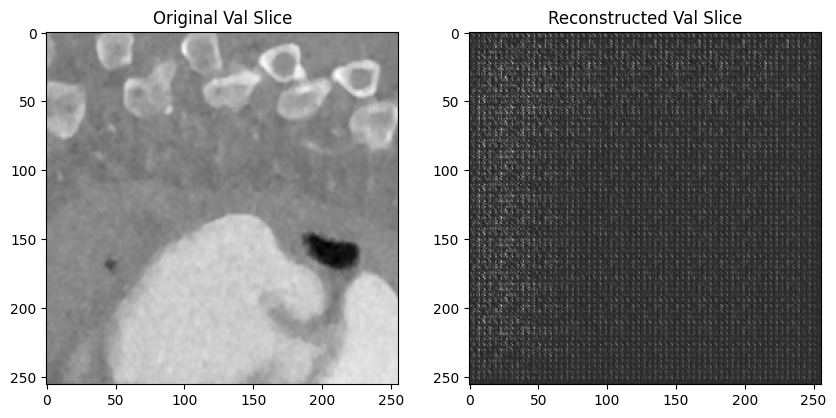

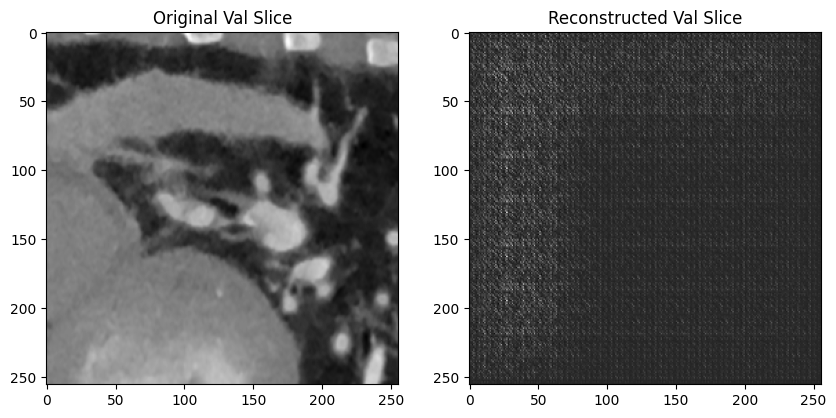

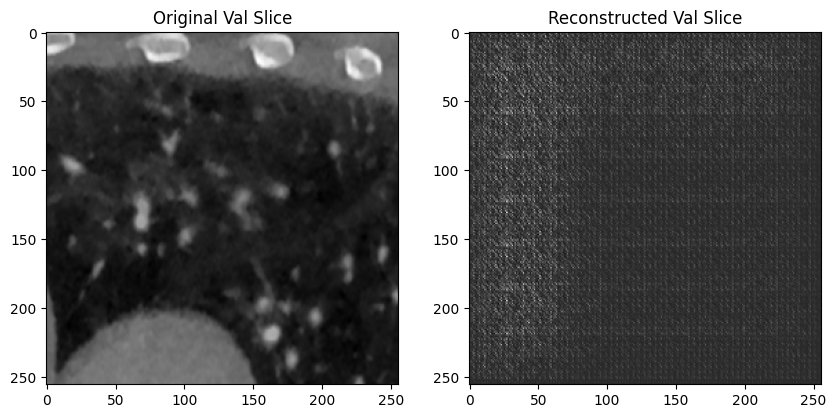

c:\Users\tgafrick\Documents\Github\RA4-Project\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\tgafrick\Documents\Github\RA4-Project\venv\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:   0%|          | 0/18 [00:00<?, ?it/s] 

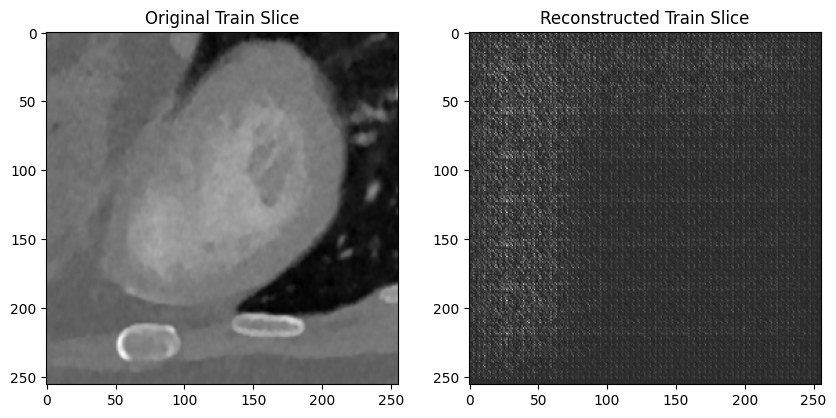

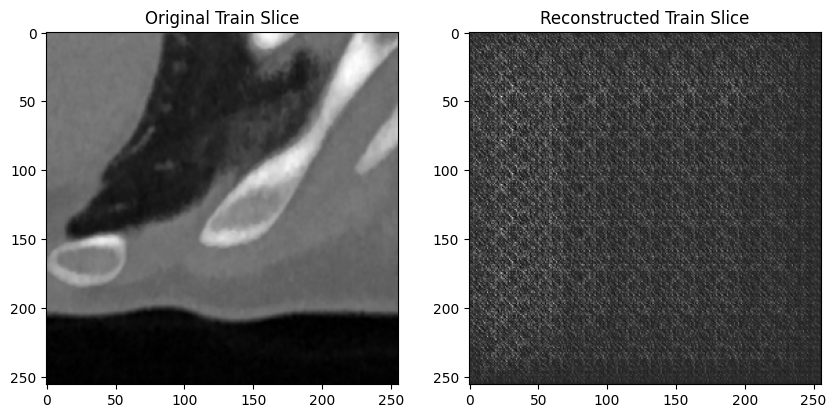

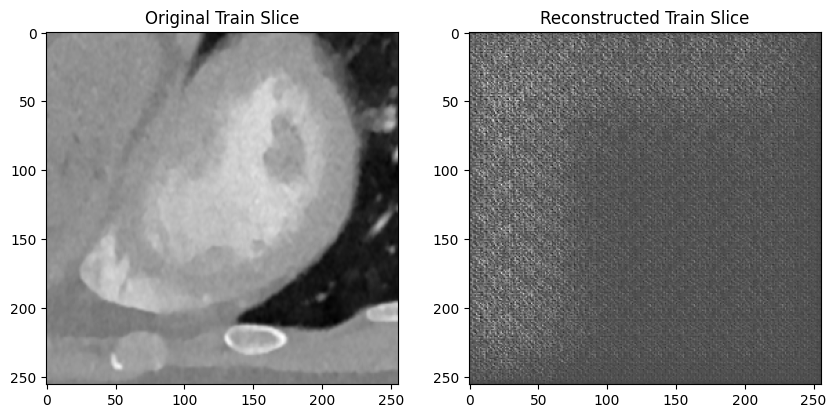

Epoch 0: 100%|██████████| 18/18 [01:15<00:00,  0.24it/s, v_num=38]

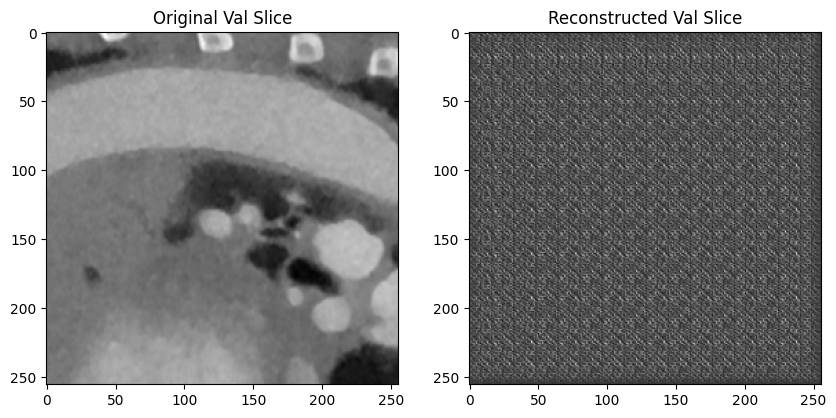

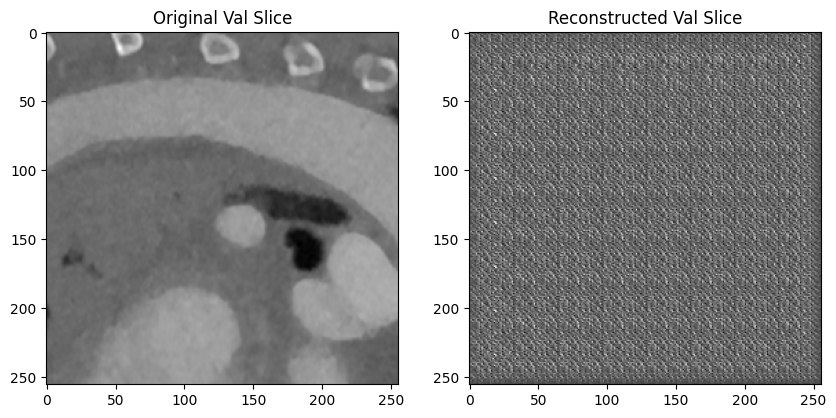

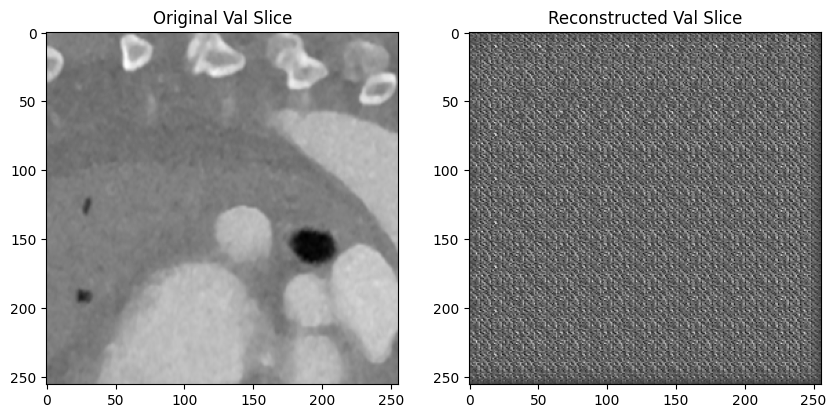

Epoch 0: 100%|██████████| 18/18 [01:33<00:00,  0.19it/s, v_num=38, val_loss=1.000]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 18/18 [01:34<00:00,  0.19it/s, v_num=38, val_loss=1.000]

FIT Profiler Report

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                           	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                            	|  -              	|  1022       

In [12]:
# Initialize model and start training
model = AutoEncoderModel()
trainer.fit(model, train_dataloader, val_dataloader)
torch.save(model.state_dict(), folder_path + '/aeSSIM.pth')